# Control CartRacing-v2 environment using DQN from scratch

In this tutorial, we will implement DQN algorithm for controllong CartRacing-v2 environment, which has the image observation space. 
We will focus more on how to convert a given raw environment into MDP environment, and we assume that the readers already have known DQN algorithm.

In [16]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

<br>

---

## CarRacing-v2 environment

Let's fir-

In [17]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


<br>

Let's see the initial state.

In [18]:
s, info = env.reset()
print(s.shape)

(96, 96, 3)


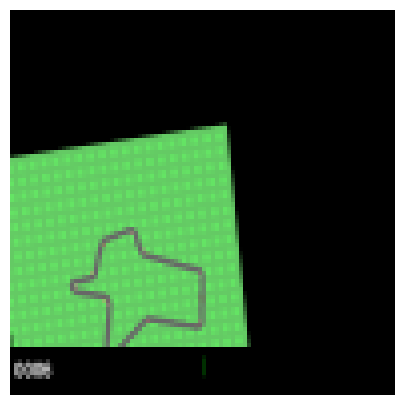

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

<br>

It looks weird... It is not what we saw... What's going on here? 
Let me do nothing (`no_op` action) for the next 50 steps.
(You don't need to write the following code)

<br>

We just saw that the game screen gradually zooms in for the first 50 steps. Of course, you can move the car during this zoom-in phase, but this zoom-in phase is a very small part of the overall game, which may hinder our agent from learning to control the car. Thus, we will not use the first 50 steps of the game.

The second thing we have to know is that we are given only one current game frame for each step. This observation setting cannot satisfy the Markov property. We cannot guess if the car is moving forward or backward from only one frame, which means we cannot predict the next frame for given the current frame. Thus, we need to stack the previous $k=4$ frames.

Let's read together some part of DQN paper.

> The raw frames are preprocessed by first converting their RGB representation to gray-scale
> <br>
> ...
> <br>
> The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.
> <br>
> ...
> <br>
> For the experiments in this paper, the function $\phi$ from algorithm 1 applies this preprocessing to the last 4 frames of a history and stacks them to produce the input to the Q-function.
> <br>
> ...
> <br>
>  we also use a simple frame-skipping technique [3]. More precisely, the agent sees and selects actions on every kth frame instead of every frame, and its last action is repeated on skipped frames.

<br>

From now on, we convert `CarRacing-v2` environment into the form above. Let's first define a function for preprocessing each game frame. 

We can use any method to resize frames into 84 X 84 ones. The easiest way is to rescale frames. But, here we utilize our knowledge about the game. Every frame always contains a black area at the bottom of the frame, so we had better cut this black area.

In [21]:
import cv2

def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

<br>

Now, we will change initial setting (`reset` method below) and observations (`step` method below).

In [22]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
    
    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        
        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info


<br>

We can create our desired environment as follows:

The shape of an observation:  (4, 84, 84)


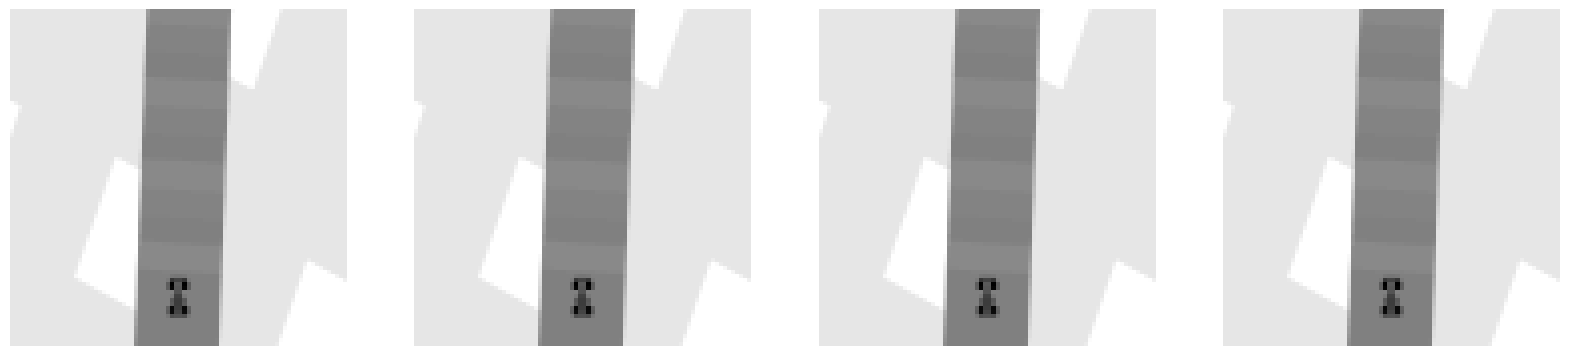

In [23]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

<br>

Let's do `gas` action for the next 4 steps. You can see our car was moving forward!
(The position of the car does not seem to change, but it is actually moving forward. See background)

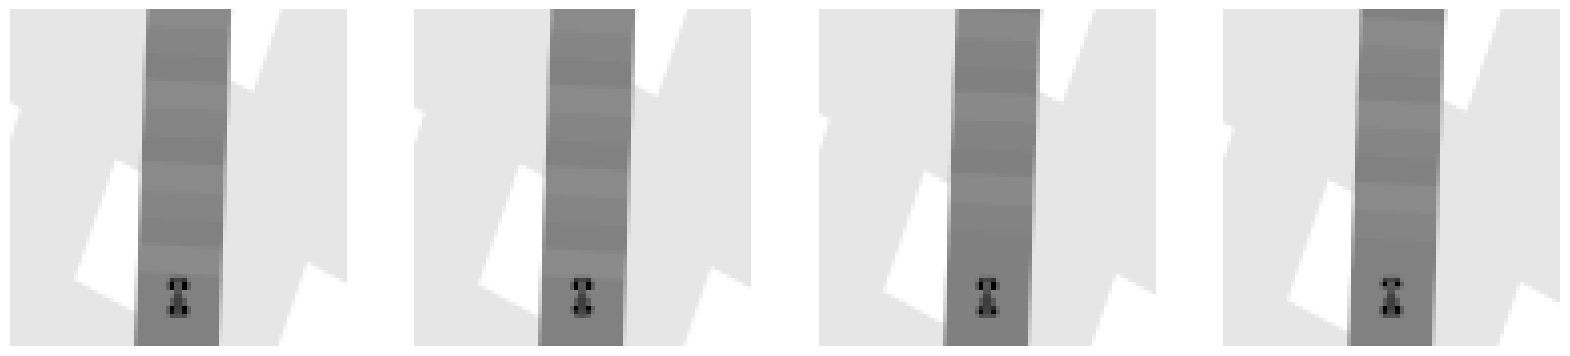

In [24]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

<br>

---

## Q-network

Let's read together some part of DQN paper.

> The input to the neural network consists is an 84 × 84 × 4 image produced by $\phi$. The first hidden layer convolves 16 8 × 8
filters with stride 4 with the input image and applies a rectifier nonlinearity [10, 18]. The second hidden layer convolves 32 4 × 4 filters with stride 2, again followed by a rectifier nonlinearity. The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fullyconnected linear layer with a single output for each valid action

In [25]:
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)  # [N, 4, 84, 84] -> [N, 16, 20, 20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features = 32 * 9 * 9
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view((-1, self.in_features))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

<br>

---

## Replay buffer

For implementation of replay buffer, the pre-creation of the required arrays is more efficient than the use of `collections.queue`.
I referenced [TD3 official implementation](https://github.com/sfujim/TD3/blob/master/utils.py#L5).

In [26]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]), 
        )

<br>

---

## DQN
DQN agent has four methods.
- `__init__`() as usual
- `act()` takes as input one state of np.ndarray and output actions by following epsilon-greedy policy.
- `process()` method takes one transition as input and define what the agent do for each step.
- `learn()` method samples a mini-batch from replay buffer and train q-network

In the DQN paper, they used replay buffer of size 1,000,000 and it requires a huge amount of memory, which cannot be loaded on my tiny RAM.  For epsilon greedy policy, they used the initial epsilon of 1.0 and linearly decrease it to 0.1 for the the first million steps, and fixed it at 0.1 after.

In [27]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e4),
        target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)
        
        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6
    
    @torch.no_grad()
    def act(self, x, training=True):
        self.network.train(training)
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.network(x)
            a = torch.argmax(q).item()
        return a
    
    def learn(self):
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        
        next_q = self.target_network(s_prime).detach()
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.item()
        }
        return result
    
    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()
            
        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon -= self.epsilon_decay
        return result

<br>

---

## Training DQN Agent
We will train DQN agent until the total number of interactions with the environment reaches 2 millilons and evaluate our agent evry 10,000 steps. The below codes will take a very long time.

In [28]:

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(10000)
eval_interval = 1000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim)

In [29]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

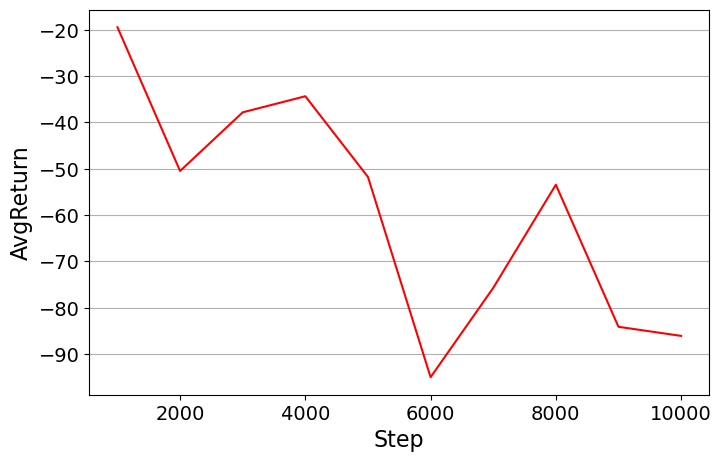

10001it [27:45,  6.00it/s]                                                                                             


In [30]:
from IPython.display import clear_output
from tqdm import tqdm  # Import tqdm

#history = {'Step': [], 'AvgReturn': }
history = {'Step': [], 'AvgReturn': []}


(s, _) = env.reset()
pbar = tqdm(total=max_steps)  # Créez la barre de progression

while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))
    
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        torch.save(agent.network.state_dict(), 'dqn.pt')
    
    pbar.update(1)  # Met à jour la barre de progression
    if agent.total_steps > max_steps:
        break

# Ferme la barre de progression à la fin de l'exécution
pbar.close()


In [15]:
from IPython.display import clear_output
from tqdm import tqdm  # Import tqdm

agent.network.load_state_dict(torch.load('C:/Users/Lenovo/Desktop/videos_racing_car/dqn.pt'))


history = {'Step': [], 'AvgReturn': []}


(s, _) = env.reset()
pbar = tqdm(total=max_steps)  # Créez la barre de progression

while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))
    
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        torch.save(agent.network.state_dict(), 'C:/Users/Lenovo/Desktop/videos_racing_car/dqn10K.pt')
    
    pbar.update(1)  # Met à jour la barre de progression
    if agent.total_steps > max_steps:
        break

# Ferme la barre de progression à la fin de l'exécution
pbar.close()


NameError: name 'agent' is not defined

<br>

---

## Evaluation

In [31]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [32]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [33]:
animate(frames,None)